
Load Preqs

In [4]:
%%capture
!pip install wfdb

In [5]:
import pandas as pd
import numpy as np
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Data Processing

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWje4jEqX6vzDB1HxwuyTFk0Gfh6YnLUn77S8Snq1NXV6NwTSkwLk50
Mounted at /content/drive


In [6]:
records = np.loadtxt("/content/drive/MyDrive/cs221project/data/RECORDS", dtype=int)

In [7]:
invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"
]
abnormal_beats = [
    "L", "R", "B", "A", "a", "J", "S", "V", 
    "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"
]
def classify_beat(symbol):
    if symbol in abnormal_beats:
        return 1
    elif symbol == "N" or symbol == ".":
        return 0

In [8]:
def get_ecg_signals(signal, beat_loc, window_size, fs):
    win_size = window_size * fs
    beat_start = beat_loc - win_size
    beat_end = beat_loc + win_size
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])

In [9]:
folder = "/content/drive/MyDrive/cs221project/data/"
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []
for subject in records:
    record = wfdb.rdrecord(f'{folder}/{subject}')
    annotation = wfdb.rdann(f'{folder}/{subject}', 'atr')
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    fs = record.fs
    scaler = StandardScaler()
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    for i, i_sample in enumerate(atr_sample):
        label = classify_beat(atr_symbol[i])
        sequence = get_ecg_signals(signal, i_sample, window_sec, fs)
        if label is not None and sequence.size > 0:
            all_sequences.append(sequence)
            subject_labels.append(label)

    normal_percentage = sum(subject_labels) / len(subject_labels)
    subject_map.append({
        "subject": subject,
        "percentage": normal_percentage,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)

In [10]:
subject_map = pd.DataFrame(subject_map)

In [11]:
bins = [0, 0.2, 0.6, 1.0]
subject_map["bin"] = pd.cut(subject_map['percentage'], bins=bins, labels=False, include_lowest=True)

In [12]:
train, validation = train_test_split(subject_map, test_size=0.25, stratify=subject_map["bin"], random_state=42)

In [13]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        start = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[start:end])
        labels.extend(all_labels[start:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [14]:
X_train, y_train = build_dataset(train, all_sequences, all_labels)
X_val, y_val = build_dataset(validation, all_sequences, all_labels)

In [15]:
X_train.shape, y_train.shape

((82873, 2160, 1), (82873, 1))

In [16]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

sequence_size = X_train.shape[1]
n_features = 1

cnn_model = Sequential([
    Conv1D(
        filters=10,
        kernel_size=3,
        strides=1,
        input_shape=(sequence_size, n_features),
        padding="same",
        activation="relu"
    ),
    Flatten(),
    Dropout(0.5),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(lr=0.001)
# Compiling the model
cnn_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2160, 10)          40        
                                                                 
 flatten (Flatten)           (None, 21600)             0         
                                                                 
 dropout (Dropout)           (None, 21600)             0         
                                                                 
 output (Dense)              (None, 1)                 21601     
                                                                 
Total params: 21,641
Trainable params: 21,641
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
hist_cnn = cnn_model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=15,
    validation_data=(X_val, y_val)
)

Epoch 1/15
648/648 [==============================] - 59s 90ms/step - loss: 0.2232 - accuracy: 0.9220 - val_loss: 0.5957 - val_accuracy: 0.8119
Epoch 2/15
648/648 [==============================] - 58s 90ms/step - loss: 0.1685 - accuracy: 0.9441 - val_loss: 0.6078 - val_accuracy: 0.8326
Epoch 3/15
648/648 [==============================] - 58s 90ms/step - loss: 0.1512 - accuracy: 0.9509 - val_loss: 0.6180 - val_accuracy: 0.8129
Epoch 4/15
648/648 [==============================] - 59s 90ms/step - loss: 0.1400 - accuracy: 0.9550 - val_loss: 0.6478 - val_accuracy: 0.8271
Epoch 5/15
648/648 [==============================] - 59s 91ms/step - loss: 0.1325 - accuracy: 0.9576 - val_loss: 0.6562 - val_accuracy: 0.8121
Epoch 6/15
648/648 [==============================] - 59s 91ms/step - loss: 0.1272 - accuracy: 0.9588 - val_loss: 0.6848 - val_accuracy: 0.8217
Epoch 7/15
648/648 [==============================] - 59s 90ms/step - loss: 0.1239 - accuracy: 0.9604 - val_loss: 0.6896 - val_accuracy:

In [18]:
cnn_model.evaluate(X_val, y_val)

821/821 [==============================] - 8s 10ms/step - loss: 0.7476 - accuracy: 0.8119


[0.7475879788398743, 0.8118740320205688]

In [ ]:
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

ImportError: ignored

<Figure size 432x288 with 1 Axes>

In [ ]:
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

ImportError: ignored

<Figure size 432x288 with 1 Axes>

In [ ]:
cnn_model.save_weights('/content/drive/MyDrive/checkpoint/cnn1d.ckpt')

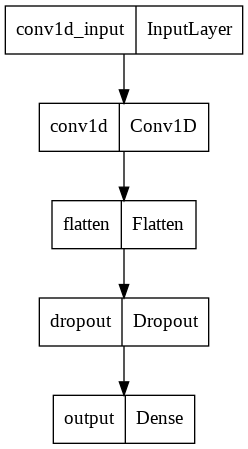

In [ ]:
tf.keras.utils.plot_model(cnn_model, to_file="model.png")